In [0]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8) # set default size of plots

In [0]:
import numpy as np

In [3]:
from keras.datasets import cifar10
from random import randrange
import time

Using TensorFlow backend.


# Полносвязная нейронная сеть
В данном домашнем задании вы подготовите свою реализацию двухслойной полносвязной нейронной сети и обучите классификатор на датасете CIFAR-10. Вы можете использовать любую из известных вам функций активации для скрытого слоя, а в качестве функции потерь  используйте cross entropy loss (его ещё иногда называют softmax loss)

Даже такая простая искуственная нейронная сеть структурно значительно сложнее, чем SVM. Организуем код в виде класса, нечто подобное используется во фреймворке Pytorch. При выполнении задания приветствуется создание новых приватных методов в классе, описывающем сеть.

In [0]:
class TwoLayerNet(object):  
    # В конструкторе зададим все веса, которые нам понадобятся
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        W1: Первый слой с размерами (D, H)
        b1: Вектор сдвигов, размер  (H,)
        W2: Второй слой с размерами (H, C)
        b2: Вектор сдвигов, размер (C,)

        Входные парамерты:
        - input_size: Размерность входных данных
        - hidden_size: Размер скрытого слоя
        - output_size: Количество классов
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y=None, reg=0.0):
        """
        Вычисление функции потерь

        Входные парамерты:
        - X: Таблица данных (N, D). X[i] - один пример
        - y: Вектор лейблов. Если отсутсвует, то возвращается предсказание лейблов
        - reg: Коэффициент регуляризации

        Возвращает:
        Если y == None, то возвращаются оценка (score) для классов

        Если y != None, то возвращаются:
        - Значение функции потерь для данного семпла данных
        - grads: Словарь градиентов, ключи соответствуют ключам словаря self.params.
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Расчет forward pass или прямой проход, для данных находятся оценки (scores),  
        # Выходная размерность (N, C), количество объектов на количество классов
        # Впишите свой код на место заглушки
        
        hidden_input, _, act_hidden, scores = self._forward_pass(X)

        # Если y == None, то завершаем вызов
        if y is None:
            return scores

        # Расчет cross entropy loss, на выходе должен получиться скаляр    
        # Впишите свой код на место заглушки
        y_ = self._one_hot(y)
        reg_term = 0.5 * reg * sum([np.sum(param**2) for param in self.params.values()])
        loss = np.sum(self._cross_entropy(scores, y_)) / N + reg_term

        grads = {}
        # Расчет обратнохо прохода или backward pass, находятся градиенты для всех параметров, 
        # результаты сохраняются в grads, например grads['W1']
        # Впишите свой код на место заглушки
        dLdout = scores - y_
        grads['W2'] = np.dot(act_hidden.T, dLdout) / N + reg * W2
        grads['b2'] = np.sum(dLdout, axis=0, keepdims=True) / N + reg * b2
        
        dLdhid = np.multiply(np.dot(dLdout, W2.T), self._dact(hidden_input))
        grads['W1'] = np.dot(X.T, dLdhid) / N + reg * W1
        grads['b1'] = np.sum(dLdhid,  axis=0, keepdims=True) / N + reg * b1

        return loss, grads
      
    def _forward_pass(self, X):
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']      
        
        inp_hidden = np.dot(X, W1) + b1
        act_hidden = self._act(inp_hidden)
        inp_final = np.dot(act_hidden, W2) + b2
        act_final = self._softmax(inp_final)
        
        return inp_hidden, inp_final, act_hidden, act_final
      
    def _act(self, x): #elementwise
        #return x * (x > 0) #relu
        return 1 / (np.exp(-x) + 1) 
    
    def _dact(self, x): #elementwise
        #return (np.sign(x) + 1) / 2      
        a = self._act(x)
        return np.multiply(a, 1 - a) 
        

    def _softmax(self, x): #by row
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)
      
    def _cross_entropy(self, y_hat, y): #by row, rows of y are prob. vectors
        eps = 1e-12
        y_hat_clip = np.clip(y_hat, eps, 1 - eps)
        return -np.sum(np.multiply(y,  np.log(y_hat_clip)), axis=-1)
      
    def _one_hot(self, y): 
        nclass = self.params['W2'].shape[1]
        N = y.shape[0]
        hot = np.zeros((N, nclass), np.int)
        hot[np.arange(N), y] = 1
        return hot
        
    def train(self, X, y, X_val, y_val,
                learning_rate=1e-3, learning_rate_decay=0.95,
                reg=5e-6, num_iters=100,
                batch_size=200, verbose=False):
        """
        Обучение нейронной сети с помощью SGD

        Входные парамерты:
        - X: Матрица данных (N, D)
        - y: Вектор лейблов (N, )
        - X_val: Данные для валидации (N_val, D)
        - y_val: Вектор лейблов валидации (N_val, )
        - reg: Коэффициент регуляризации
        - num_iters: Количнство итераций
        - batch_size: Размер семпла данных, на 1 шаг алгоритма
        - verbose: Вывод прогресса
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):

            # Выбираем минибатч из выборки и заполняем X_batch и y_batch
            # Впишите свой код на место заглушки
            #todo: nonrandom batch
            idx = np.random.choice(X.shape[0], batch_size, replace=False)
            X_batch = X[idx,:]
            y_batch = y[idx]
 
            # Производим рассчёт значения функции потерь и градиентов
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            # Используя градиенты из grads обновите параметры сети. 
            # Hint: ключи в словарях градиентов и параметров должны совпадать, можно по ним проитерировать
            # Впишите свой код на место заглушки
            for param_name in self.params:
              self.params[param_name] = self.params[param_name] - grads[param_name] * learning_rate
            
            if verbose and it % 100 == 0:
                print(f'iteration {it}/{num_iters}: loss {loss:.4f}')

            if it % iterations_per_epoch == 0:
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                
                # Уменьшаем learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Входные параметры:
        - X: Матрица данных (N, D)

        Возвращает:
        - y_pred: Вектор предсказаний классов для обьектов (N,)
        """

        # Предсказание классов для обьектов из X     
        # Впишите свой код на место заглушки
        _, _, _, scores = self._forward_pass(X)
        y_pred = np.argmax(scores, axis=-1)
      
        return y_pred

# Тестируем написанный код

Ниже приведена функция, осуществляющая численную проверку градиента.

In [0]:
def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y)))) 

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    
    fx = f(x)
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h 
        fxph = f(x) 
        x[ix] = oldval - h
        fxmh = f(x) 
        x[ix] = oldval 

        # Вычисляем частную производную
        grad[ix] = (fxph - fxmh) / (2 * h) 
        if verbose:
            print(ix, grad[ix])
        it.iternext() 

    return grad

Сгенерируем простые данные и выполним тест.

In [0]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X_toy, y_toy = init_toy_data()

In [32]:
r = 0.0
loss, grads = net.loss(X_toy, y_toy, reg=r)

# Ошибка должна быть меньше или около 1e-8
for param_name in grads:
    
    f = lambda _: net.loss(X_toy, y_toy, reg=r)[0] # функция не использует аргумент, это нормально :)
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 6.369010e-10
b2 max relative error: 4.447625e-11
W1 max relative error: 1.115566e-09
b1 max relative error: 2.738420e-09


Реализуйте метод `TwoLayerNet.train` и метод `TwoLayerNet.predict`

Обучите сеть на игрушечных данных, которые мы сгенерировали выше, значение функции потерь дольжно быть меньше или около $0.2$.

Final training loss:  0.16620160678544796


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


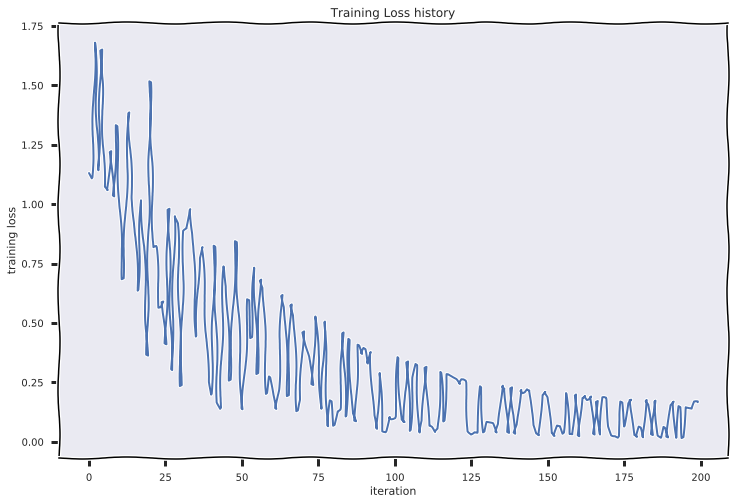

In [28]:
net = init_toy_model()
stats = net.train(X_toy, y_toy, X_toy, y_toy,
            learning_rate=1e-2, reg=5e-6,
            num_iters=200, verbose=False, batch_size=1)

print('Final training loss: ', stats['loss_history'][-1])
with plt.xkcd():
    plt.plot(stats['loss_history'])
    plt.xlabel('iteration')
    plt.ylabel('training loss')
    plt.title('Training Loss history')
    plt.show()

# Обучение сети
Теперь, когда всё готово, вы можете обучить сеть на данных CIFAR-10

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


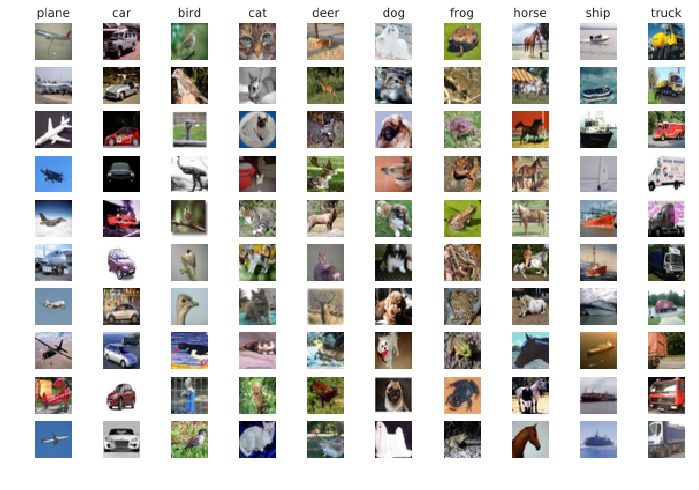

In [76]:
with plt.xkcd():
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_classes = len(classes)
    samples_per_class = 10
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(x_train[idx].astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()

In [77]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
y_train = np.squeeze(y_train, 1)
y_test = np.squeeze(y_test, 1)


# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)


Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[130.71074 136.05614 132.5538  130.14036 135.44238 131.85358 131.05044
 136.24616 132.58144 131.56886]


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


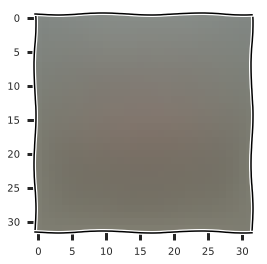

In [78]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
with plt.xkcd():
    plt.figure(figsize=(4,4))
    plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
    plt.show()

In [0]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [0]:
n_samples = x_train.shape[0]
test_size = int(0.05 * n_samples) #added by me
x_val, y_val = x_train[:test_size], y_train[:test_size]
x_train, y_train = x_train[test_size:], y_train[test_size:]

In [85]:
input_size = 32 * 32 * 3
hidden_size = 500
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

stats = net.train(x_train, y_train, x_val, y_val,
            num_iters=10000, batch_size=200,
            learning_rate=5e-2, learning_rate_decay=0.8,
            reg=0.0001, verbose=True)

def accuracy(y_true, y):
  return  np.mean(y_true == y)

print('Validation accuracy: ', accuracy(net.predict(x_val), y_val))

iteration 0/10000: loss 2.3025
iteration 100/10000: loss 1.8657
iteration 200/10000: loss 1.8310
iteration 300/10000: loss 1.7712
iteration 400/10000: loss 1.7308
iteration 500/10000: loss 1.6849
iteration 600/10000: loss 1.7182
iteration 700/10000: loss 1.6888
iteration 800/10000: loss 1.6264
iteration 900/10000: loss 1.6107


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in exp


iteration 1000/10000: loss 1.5968
iteration 1100/10000: loss 1.6777
iteration 1200/10000: loss 1.6991
iteration 1300/10000: loss 1.6274
iteration 1400/10000: loss 1.7608
iteration 1500/10000: loss 1.7200
iteration 1600/10000: loss 1.7538
iteration 1700/10000: loss 1.6083
iteration 1800/10000: loss 1.6567
iteration 1900/10000: loss 1.6174
iteration 2000/10000: loss 1.6852
iteration 2100/10000: loss 1.6488
iteration 2200/10000: loss 1.5078
iteration 2300/10000: loss 1.6288
iteration 2400/10000: loss 1.4729
iteration 2500/10000: loss 1.5907
iteration 2600/10000: loss 1.4592
iteration 2700/10000: loss 1.3977
iteration 2800/10000: loss 1.6398
iteration 2900/10000: loss 1.4320
iteration 3000/10000: loss 1.5529
iteration 3100/10000: loss 1.4770
iteration 3200/10000: loss 1.5559
iteration 3300/10000: loss 1.5945
iteration 3400/10000: loss 1.5055
iteration 3500/10000: loss 1.4691
iteration 3600/10000: loss 1.4498
iteration 3700/10000: loss 1.3922
iteration 3800/10000: loss 1.3886
iteration 3900

# Дебаг процесса обучения

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


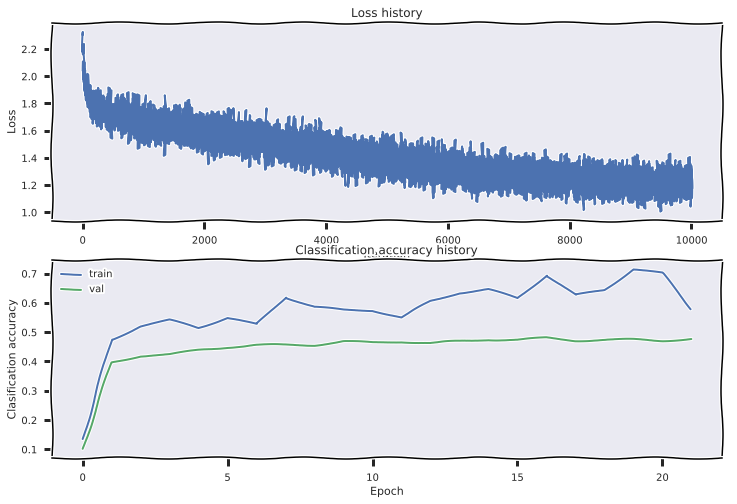

In [86]:
with plt.xkcd():
    plt.subplot(2, 1, 1)
    plt.plot(stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    t_acc = plt.plot(stats['train_acc_history'], label='train')
    v_acc = plt.plot(stats['val_acc_history'], label='val')
    plt.legend()
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.show()

# Настройка гиперпараметров

In [81]:
# Напишите свою реализцию кросс валидации для настройки гиперпараметров сети    
# Впишите свой код на место заглушки

default_args = {'num_iters':2500, 'batch_size':200, 'learning_rate':5e-2,
                'learning_rate_decay':0.8, 'verbose':False}

nets = [(TwoLayerNet(input_size, 500, num_classes), {'reg':1e-1}),
        (TwoLayerNet(input_size, 500, num_classes), {'reg':1e-2}),
        (TwoLayerNet(input_size, 500, num_classes), {'reg':1e-4}),
        (TwoLayerNet(input_size, 500, num_classes), {'reg':1e-6}),
        (TwoLayerNet(input_size, 1000, num_classes), {'reg':1e-1}),
        (TwoLayerNet(input_size, 1000, num_classes), {'reg':1e-2}),
        (TwoLayerNet(input_size, 1000, num_classes), {'reg':1e-4}),
        (TwoLayerNet(input_size, 1000, num_classes), {'reg':1e-6})]

acc_scores = []
for net, params in nets:
  args = default_args.copy()
  args.update(params)
  net.train(x_train, y_train, x_val, y_val, **args)
  pred = net.predict(x_val)
  acc = accuracy(y_val, pred)
  acc_scores.append(acc)
  print(acc)
  
best_net = nets[np.argmax(acc_scores)][0]
print('Validation accuracy: ', np.max(acc_scores))    


0.4644


KeyboardInterrupt: ignored

# Проверка качества
С оптимальными гиперпараметрами сеть должна выдавать точнов около 48%.

In [87]:
print('Test accuracy: ', accuracy(best_net.predict(x_test), y_test)) 


Test accuracy:  0.4543


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in exp
